In [1]:
from src import sensor_reader as sr
from src import graphs, style
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cycler

n = 100
color = plt.cm.Reds_r(np.linspace(0.1, 0.9,n))
matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

style.set_rc_eb_standard()


In [2]:
def thermal_comfort_1(TAMB, TROOM, ax=None, mode='op',ms=None,legend_ms=None):
    """Erstelle ein Diagramm zur Evaluation des thermischen Komoforts nach DIN 15251 - NA.1

    Keyword arguments:
    :param TAMBG -- Außentemperatur, mittelwert in stündlichen Schritten. Übergabe als pd.Series oder pd.DataFrame.
    :param TROOM -- Raumtemperatur. stündliche Mittelwerte. Übergabe als pd.Series oder pd.DataFrame.
    :param ax -- plt.axes instanz zum plotten des graphen
    :param mode -- 'air' für Lufttemperatur, 'op' für operative Temperatur
    """
    df = pd.concat([TAMB,TROOM],axis=1)
    df.columns = ['TAMB', 'TROOM']
    df.dropna(inplace=True)
    length_data = df.shape[0]
    x = np.linspace(-30,40)
    y=[]

    for t in x:
        if t < 16:
            y.append(22)
        if 16 <= t <= 32:
            y.append(18 + 0.25*t)
        if t > 32:
            y.append(26)

    comf = ((
        df[(df.TAMB < 16) & (df.TROOM > 20) & (df.TROOM < 24)].shape[0]
        +df[((df.TAMB >= 16) & (df.TAMB <= 32)) & (df.TROOM < 20 + 0.25*df.TAMB) & (df.TROOM > 16 + 0.25*df.TAMB)].shape[0]
        +df[(df.TAMB > 32) & (df.TROOM > 24) & (df.TROOM < 28)].shape[0]
        ) / length_data) * 100

    untergradstunden = (
        df[(df.TAMB < 16) & (df.TROOM < 20)].shape[0] 
        + df[((df.TAMB >= 16) & (df.TAMB <= 32)) & (df.TROOM < 16 + 0.25*df.TAMB)].shape[0]
        +df[(df.TAMB > 32) & (df.TROOM < 24)].shape[0])

    uebergradstunden = (
        df[(df.TAMB < 16) & (df.TROOM > 24)].shape[0] 
        + df[((df.TAMB >= 16) & (df.TAMB <= 32)) & (df.TROOM > 20 + 0.25*df.TAMB)].shape[0]
        +df[(df.TAMB > 32) & (df.TROOM > 28)].shape[0])

    if not ax:
        fig, ax = plt.subplots()

    ax.plot(x, y, c='k',ls = 'dashed', label = 'Komforttemperatur')

    #ax.plot(x, [(t+2,t-2) for t in y], c='k',ls = 'solid')

    ax.fill_between(
        x, 
        [t+2 for t in y], 
        [t-2 for t in y], 
        color="0.8",
        label = 'Komfortbereich')

    ax.annotate(
        r"$\textbf{" + str(int(comf)) + str('\%') + "}$" + f' der Messpunkte\nim Komfortbereich',
        xy=(df.TAMB.mean(), df.TROOM.mean()), 
        xycoords='data',
        xytext=(0.35, 0.85), 
        textcoords='axes fraction',
        arrowprops=dict(arrowstyle="->"),
        bbox=style.eb_bbox,
        horizontalalignment='center', 
        verticalalignment='top')

    if uebergradstunden > 0:
        text1 = r"$\textbf{" + str('Übergradstunden') + "}$" + f':\n{uebergradstunden}'
        ax.text(
            0.02,
            0.94, 
            text1.strip(),      
            style='normal', 
            ha = 'left', 
            va = 'top',
            transform=ax.transAxes,
            #bbox=style.eb_bbox, 
            )
    if untergradstunden > 0:
        text2 = r"$\textbf{" + str('Untergradstunden') + "}$" + f':\n{untergradstunden}'
        ax.text(
            0.98,
            0.06, 

            text2.strip(),      
            style='normal', 
            ha = 'right', 
            va = 'bottom',
            transform=ax.transAxes,
            #bbox=style.eb_bbox, 
            )

    ax.plot(
        df['TAMB'], df['TROOM'],
        #color=ut.truncate_colormap('Reds_r',0,0.8)(0.1),
        marker = 'o',
        mfc='none',
        linestyle='None',
        ms=ms,
        alpha=0.75,
        label = 'Raumlufttemperatur im Verhältnis zur Außenlufttemperatur'
        )

    ax.set_xlim(-15, 40)
    ax.set_ylim(15, 30)

    ax.set_xlabel('Außenlufttemperatur °C')

    if mode == 'op':
        ax.set_ylabel('operative Raumtemperatur [°C]')
    if mode == 'air':
        ax.set_ylabel('Raumlufttemperatur [°C]')

    ax.set_title('Adaptives Komfortmodell nach DIN EN 15251-1 - NA.1', fontweight = 'bold', loc='center')
    
    ax.legend(
        #loc='lower right',
        loc='upper center',
        markerscale = legend_ms,
        ncol=99,
        #bbox_to_anchor=(1,1.1),
        frameon=False)

In [3]:
df = sr.load_tf_bui('LB')['N']['WZ'].filter(like='m_trh')
amb = sr.load_tf_weather()

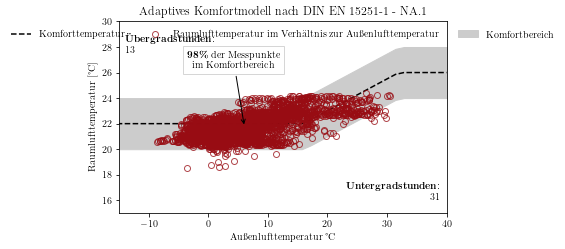

In [4]:
fig, ax = plt.subplots()

thermal_comfort_1(amb['T_amb'], df['m_trh_Tair (°C)'], ax=ax, mode='air')